In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from __future__ import print_function

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Embedding, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.regularizers import l2
from keras.utils.data_utils import get_file
import numpy as np
import numpy.random as nr
import random
import glob
import sys
import os
import re

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

os.makedirs('../../models',exist_ok=True)
np.set_printoptions(precision=3, linewidth=120)

Using TensorFlow backend.


In [2]:
import keras.backend as K

# K.set_image_data_format('channels_first')
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


In [3]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, model_name, X_train, y_train, Xval=None, yval=None, loss="categorical_crossentropy",
                  metrics=('accuracy',), opt='rmsprop', batch_size=60, nepochs=50000, patience=500, 
                  nr_seed=20170522, reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss=loss, optimizer=opt, metrics=metrics)    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if tr_epochs <= 0:
        print('[INFO] Model already trained for {} epochs'.format(nepochs))
        return model, cb
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2
        
    if Xval is not None:
        val_data = (Xval, yval)
    else:
        val_data = None

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=60, epochs=tr_epochs, verbose=0, 
                      validation_data=val_data, callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb


def test_network(model_name, X_test, y_test):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


In [4]:
data_dir = '../../datasets/'

def clean_text(text):
    txt = re.sub('\n\n+', '\07', text)
    txt = re.sub('\n', ' ', txt)
    txt = re.sub('\07', '\n', txt)
    txt = re.sub('  +', ' ', txt)
    txt = re.sub('\nCAPÍTULO [^\n]*\n', '\n', txt)    
    return txt.lower()

book_texts = []
book_titles = []
char_count = 0
for fn in glob.glob(data_dir + 'livros/Machado_de_Assis__*.txt'):
    _, book = os.path.basename(fn).split('__')
    txt = open(fn, encoding='utf-8').read()
    txt = clean_text(txt)
    book_texts.append(txt)
    book_titles.append(book[:-4])
    print('{:7d}  {}'.format(len(txt), book[:-4]))
    char_count += len(txt)
print('{:7d}'.format(char_count))

nb_books = len(book_texts)


 347400  Memorias_Postumas_de_Bras_Cubas
 280008  Memorial_de_Aires
 408432  Esau_e_Jaco
 369465  Dom_Casmurro
 326196  Iaia_Garcia
 440240  Quincas_Borba
 327155  Helena
2498896


In [5]:
all_text = ''
for txt in book_texts:
    all_text += txt
    
chars = sorted(list(set(all_text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

nb_chars = len(chars)
text_len = len(all_text)

print('total text length: ', text_len, 'chars')
print('total unique chars:', nb_chars)
print(chars)


total text length:  2498896 chars
total unique chars: 82
['\n', ' ', '!', '"', '$', '&', "'", '(', ')', '*', '+', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\x92', '\x93', '\x94', '\x96', '\x97', '\xa0', '¡', 'ª', '°', 'º', 'à', 'á', 'â', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ó', 'ô', 'õ', 'ú', 'ü']


In [6]:
idx = nr.randint(text_len - 400)
print(all_text[idx:idx+400])

 antigas dobras de ouro, e eu levava-lhe quantas podia obter; marcela juntava-as todas dentro de uma caixinha de ferro, cuja chave ninguém nunca jamais soube onde ficava; escondia-a por medo dos escravos. a casa em que morava, nos cajueiros, era própria. eram sólidos e bons os móveis, de jacarandá lavrado, e todas as demais alfaias, espelhos, jarras, baixela,  uma linda baixela da índia, que lhe 


In [7]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(book_texts)
sequences = tokenizer.texts_to_sequences(book_texts)

w2i = tokenizer.word_index
i2w = dict([(v, k) for k, v in w2i.items()])

i2w_vec = np.array([i2w[i+1] for i in range(len(i2w))])

print('Found %d unique tokens.' % len(i2w))
print('Using the first %d words.' % max([max(s) for s in sequences]))
print([len(s) for s in sequences])

Found 25471 unique tokens.
Using the first 19999 words.
[60678, 51325, 72381, 66715, 56526, 77741, 55994]


In [8]:
seq_len = 10
step = 3
sentences = []
for k, sequence in enumerate(sequences):
    for i in range(0, len(sequence) - (seq_len + 1), step):
        sentences.append(sequence[i: i + seq_len + 1])

print('nb sequences:', len(sentences))

nb sequences: 147097


In [9]:
print('Vectorization ...')
nb_samples = len(sentences)

X = np.zeros((nb_samples, seq_len), dtype=np.int)
y = np.zeros((nb_samples,), dtype=np.int)
for i, sentence in enumerate(sentences):
    X[i, :] = sentence[:-1]
    y[i] = sentence[-1]
    
print('X.shape:', X.shape)
print('y.shape:', y.shape)


Vectorization ...
X.shape: (147097, 10)
y.shape: (147097,)


In [10]:
for i in nr.randint(nb_samples, size=(20,)):
    print(X[i], y[i])
    print(' '.join([i2w[x] for x in X[i]]), '->', i2w[y[i]])
    print()

[  29  368   25  277   25  212   25 1312    4    8] 72
na política por gosto por família por ambição e um -> pouco

[  99 1627   13    8  254 5442    6  146  409    3] 509
helena lançou lhe um olhar suspeitoso não sei ler de -> cor

[3262 7290    9 8468 8541   10  360 6436    9 1982] 4
aparências rutilantes do arruído frouxidão da vontade domínio do capricho -> e

[  43   35   25  115 3239 2217   95   19  697    9] 78
olhos nem por isso dormiu tentou então uma página do -> seu

[   1   54  794  103   13    1 1829 1915  699    6] 846
a outra quisera ver lhe a miséria digna contudo não -> pude

[    8 17053  2938    10    98  1001     5   196   820     9] 61
um ciclo inteiro da vida humana o primeiro número do -> meu

[  742    26  2629    10   153     6 13417   325   184     3] 124
pensando no lance da carta não compreendendo aquele gesto de -> mão

[  326    71  1389  5371    20   574 10338    23   558   771] 37
quatro dias irei apresentar as minhas felicitações ao novo ministro -> dos

In [11]:
model = Sequential()
model.add(Embedding(num_words, 50, input_length=seq_len, embeddings_regularizer=l2(1e-5)))
model.add(LSTM(128))
model.add(BatchNormalization())
model.add(Dense(num_words, activation='softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 50)            1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               91648     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 20000)             2580000   
Total params: 3,672,160
Trainable params: 3,671,904
Non-trainable params: 256
_________________________________________________________________


In [12]:
from sklearn.model_selection import train_test_split

X_tra, X_val, y_tra, y_val = train_test_split(X, y, test_size=0.1)
print(X_tra.shape, y_tra.shape, X_val.shape, y_val.shape)

(132387, 10) (132387,) (14710, 10) (14710,)


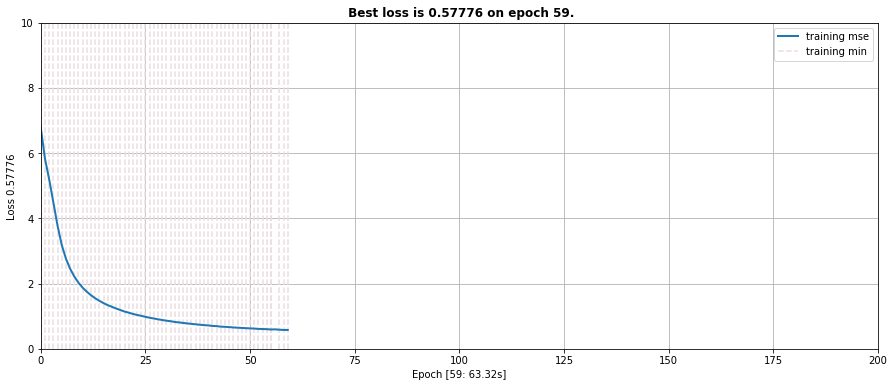

In [13]:
model_name = '../../models/lstm_machado_words_2'

fit_params = {
    'opt':        Adam(),
    'loss':       'sparse_categorical_crossentropy',
    'metrics':    ['accuracy'],
    'batch_size': 100, 
    'nepochs':    200,
    'patience':   15,
    'ploss':      10.0,
    'reset':      False,
}

N = -1
Xtra, ytra = X_tra[:N], y_tra[:N]

train_network(model, model_name, Xtra, ytra, **fit_params);


In [17]:
model, histo = load_model_and_history(model_name)

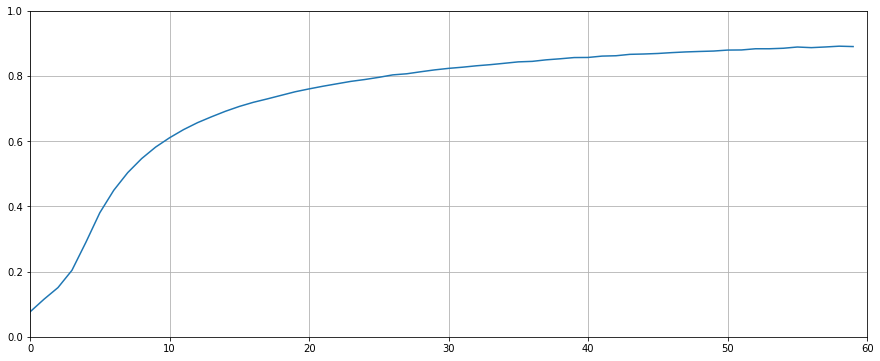

In [18]:
acc = [dd['acc'] for dd in histo.history]
nepochs = len(acc)

fig = plot.figure(figsize=(15,6))
plot.ylim(0.0, 1.0)
plot.xlim(0, nepochs)
plot.grid(True)

plot.plot(acc)


In [16]:
def get_string(seq):
    return

all_words = []
for seq in sequences:
    all_words += seq
corpus_word_count = len(all_words)

start_index = random.randint(0, corpus_word_count - seq_len - 1)
generated = []
sentence = all_words[start_index: start_index + seq_len]
generated += sentence
print(' '.join([i2w[x] for x in generated]))
print('-----')


for i in range(40):
    x = np.array(sentence).reshape(1, -1)
    preds = model.predict(x, verbose=0)[0]
    next_word = np.argmax(preds)
    
    generated += [next_word]
    sentence = sentence[1:] + [next_word]

    if i%10 == 0:
        print(' '.join([i2w[x] for x in generated]))
        print('-'*60)


é que não sei mas poucos  em todo o
-----
é que não sei mas poucos  em todo o caso
------------------------------------------------------------
é que não sei mas poucos  em todo o caso de fazer um gesto de outro nos olhos como mas
------------------------------------------------------------
é que não sei mas poucos  em todo o caso de fazer um gesto de outro nos olhos como mas não fosse então e foi guardar o seu quarto para
------------------------------------------------------------
é que não sei mas poucos  em todo o caso de fazer um gesto de outro nos olhos como mas não fosse então e foi guardar o seu quarto para ver onde está e viu entrar com um colar como
------------------------------------------------------------
